# Import Dependencies

In [1]:
import os
import cv2
import time
import retro
import optuna
import numpy as np
from gym import Env 
from stable_baselines3 import PPO
from matplotlib import pyplot as plt
from gym.spaces import MultiBinary, Box
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

# Setup Game

In [5]:
env = retro.make("StreetFighterIISpecialChampionEdition-Genesis")

In [3]:
env.close()

In [ ]:
print("Observation Space: ", env.observation_space.shape, env.observation_space, env.observation_space.sample())
print("Action Space: ", env.action_space.shape, env.action_space, env.action_space.sample())

In [6]:
# Reset game to starting state
obs = env.reset()
# Set flag to flase
done = False
for game in range(1): 
    while not done: 
        if done: 
            obs = env.reset()
        env.render()
        obs, reward, done, info = env.step(env.action_space.sample())
        time.sleep(0.01)
        print(reward)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
500.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

KeyboardInterrupt: 

# Setup Environment

In [2]:
# Create custom environment 
class StreetFighter(Env): 
    def __init__(self):
        super().__init__()
        # Specify action space and observation space 
        self.observation_space = Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)
        self.action_space = MultiBinary(12)
        # Startup and instance of the game 
        self.game = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis', use_restricted_actions=retro.Actions.FILTERED)
    
    def reset(self):
        # Return the first frame 
        obs = self.game.reset()
        obs = self.preprocess(obs) 
        self.previous_frame = obs 
        
        # Create a attribute to hold the score delta 
        self.score = 0 
        return obs
    
    def preprocess(self, observation): 
        # Grayscaling 
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        # Resize 
        resize = cv2.resize(gray, (84,84), interpolation=cv2.INTER_CUBIC)
        # Add the channels value
        channels = np.reshape(resize, (84,84,1))
        return channels 
    
    def step(self, action): 
        # Take a step 
        obs, reward, done, info = self.game.step(action)
        obs = self.preprocess(obs) 
        
        # Frame delta 
        frame_delta = obs - self.previous_frame
        self.previous_frame = obs 
        
        # Reshape the reward function
        reward = info['score'] - self.score 
        self.score = info['score'] 
        
        return frame_delta, reward, done, info
    
    def render(self, *args, **kwargs):
        self.game.render()
        
    def close(self):
        self.game.close()

In [10]:
env = StreetFighter()

In [9]:
env.close()

In [ ]:
print(env.observation_space.shape)
print(env.action_space.shape)

In [11]:
obs = env.reset()

In [16]:
obs, reward, done, info = env.step(env.action_space.sample())

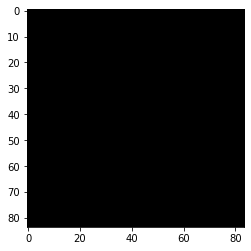

In [17]:
plt.imshow(cv2.cvtColor(obs, cv2.COLOR_BGR2RGB))

# Hyperparameter Tuning

In [3]:
LOG_DIR = './logs/'
OPT_DIR = './opt/'
CHECKPOINT_DIR = './train/'

In [4]:
# Function to return test hyperparameters - define the object function
def optimize_ppo(trial): 
    return {
        'n_steps':trial.suggest_int('n_steps', 2048, 8192),
        'gamma':trial.suggest_loguniform('gamma', 0.8, 0.9999),
        'learning_rate':trial.suggest_loguniform('learning_rate', 1e-5, 1e-4),
        'clip_range':trial.suggest_uniform('clip_range', 0.1, 0.4),
        'gae_lambda':trial.suggest_uniform('gae_lambda', 0.8, 0.99)
    }

In [5]:
# Run a training loop and return mean reward 
def optimize_agent(trial):
    try:
        model_params = optimize_ppo(trial) 

        # Create environment 
        env = StreetFighter()
        env = Monitor(env, LOG_DIR)
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env, 4, channels_order='last')

        # Create algo 
        model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=0, **model_params)
        model.learn(total_timesteps=50000)

        # Evaluate model 
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
        env.close()

        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)

        return mean_reward

    except Exception as e:
        return -1000

In [ ]:
env.close()

In [ ]:
# Creating the experiment 
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent, n_trials=30, n_jobs=1)

In [ ]:
model = PPO.load(os.path.join(OPT_DIR, 'trial_9_best_model.zip'))

# Setup Callback

In [ ]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [ ]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

# Train Model

In [ ]:
# Create environment 
env = StreetFighter()
env = Monitor(env, LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [ ]:
model_params = study.best_params
model_params['n_steps'] = 7488
model_params['learning_rate'] = 5e-7
model_params

In [ ]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, **model_params)

In [ ]:
model.load(os.path.join(OPT_DIR, 'trial_9_best_model.zip'))

In [ ]:
model.learn(total_timesteps=1000000, callback=callback)

# Evaluate Model

In [ ]:
model = PPO.load('./opt/trial_24_best_model.zip')

In [ ]:
mean_reward, _ = evaluate_policy(model, env, render=True, n_eval_episodes=1)

In [ ]:
mean_reward

# Test Model

In [ ]:
obs = env.reset()

In [ ]:
obs.shape

In [ ]:
env.step(model.predict(obs)[0])

In [ ]:
# Reset game to starting state
obs = env.reset()
# Set flag to flase
done = False
for game in range(1): 
    while not done: 
        if done: 
            obs = env.reset()
        env.render()
        action = model.predict(obs)[0]
        obs, reward, done, info = env.step(action)
        time.sleep(0.001)
        if reward > 0: 
            print(reward)